## NLP Assignment-2
### Mohammed Alom
### Student Number R00144214
### Task-1: Based on Reddit dataset Chatbot.
##### Reference - Dataset was collected from
I would like to acknowledge and thanks all the reference materials. This code and ideas is taken from an open source different github repos and blogs and been tweeked in the code to meet the requirements.
1. https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

#### Readme
#### How to Run:

1. To start chatting please goto Menu ->Runtime-> Run all or directly press (ctrl + F9) from keyboard.
 

In [4]:
!ls

drive  sample_data


##Part -1: Importing libraries and Download dataset and Pre-process data.

In [5]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from scipy.ndimage.interpolation import shift
from keras.models import load_model
import keras
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
%matplotlib inline

####Connected with google colab TPU

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


####Connecting with google drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import sys
import os
#os.chdir("/content/drive/My Drive/Colab Notebooks/chatbot/")
#os.listdir()
#%cd /content/drive/My Drive/Colab Notebooks/

#py_file_location = "/content/drive/My Drive/Colab Notebooks/"
#sys.path.append(os.path.abspath(py_file_location))

####Setting the parameters.

In [9]:
nb_samples = 25000
nb_words  = 1000

In [10]:
def return_text(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    return lines

####Getting the data from google drive

In [11]:
# test_from = return_text('/content/drive/My Drive/Colab Notebooks/chatbotReddit/data/test.from')
train_from = return_text('/content/drive/My Drive/Colab Notebooks/chatbotReddit/data/train.from')
# test_to = return_text('/content/drive/My Drive/Colab Notebooks/chatbotReddit/data/test.to')
train_to = return_text('/content/drive/My Drive/Colab Notebooks/chatbotReddit/data/train.to')

####Processing the data

In [12]:
def clean_sentences(sentences):
    n_sentences=[]
    temp = ''
    for sentence in sentences:
        if '\n' in sentence:
            loc = sentence.find('\n')
        temp = "sos "+sentence[:loc] + " eos"
        n_sentences.append(temp)
        temp=''
    return n_sentences

In [13]:
cleaned_trainfrom = clean_sentences(train_from)
cleaned_trainto = clean_sentences(train_to)

In [14]:
cleaned_trainfrom[0]

'sos As always Dilbert is so true. newlinechar  newlinechar Funny thing about Strategy is that you can have the right Strategy and still find yourself worse off. eos'

In [15]:
tokenizer = Tokenizer(num_words = nb_words,lower=True)
tokenizer.fit_on_texts(cleaned_trainfrom + cleaned_trainto)

In [16]:
len(tokenizer.word_index)

48311

In [17]:
train_from_sequences = tokenizer.texts_to_sequences(cleaned_trainfrom)
train_to_sequences = tokenizer.texts_to_sequences(cleaned_trainto)

In [18]:
# test_to_sequences = tokenizer.texts_to_sequences(test_to)
# test_from_sequences = tokenizer.texts_to_sequences(test_from)

In [19]:
max_seq_train_from = max([len(seq) for seq in train_from_sequences])
max_seq_train_to = max([len(seq) for seq in train_to_sequences])

In [20]:
max_seq_train_from,max_seq_train_to

(87, 77)

In [21]:
data_trainfrom = pad_sequences(train_from_sequences, maxlen=max_seq_train_from)
data_trainto = pad_sequences(train_to_sequences, maxlen=max_seq_train_to)

In [22]:
# data_testfrom = pad_sequences(train_from_sequences, maxlen=max_seq_train_from)
# data_testto = pad_sequences(train_to_sequences, maxlen=max_seq_train_to)

In [23]:
data_trainfrom[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  31, 179,
        13,  36, 214,   4,   4, 285, 132,  48,  13,  12,  10,  49,  20,
         3,  92,   9, 101, 192, 430, 515, 129,   2], dtype=int32)

In [24]:
# data_trainfrom = data_trainfrom[:nb_samples]
# data_trainto = data_trainto [:nb_samples]

In [25]:
data_trainfrom.shape,data_trainto.shape

((28778, 87), (28778, 77))

In [26]:
# def shift2(arr,num):
#     arr=np.roll(arr,num)
#     if num<0:
#          np.put(arr,range(len(arr)+num,len(arr)),0)
#     elif num > 0:
#          np.put(arr,range(num),0)
#     return arr

In [27]:
# target_data = shift2(data_trainto, -1)
# target_data = target_data[:nb_samples]

In [28]:
new_tokens = {}
for token, val in  tokenizer.word_index.items():
  if(val<nb_words):
    if re.match('^[a-zA-Z0-9]',token ):
        new_tokens[token] = val
  else:
    break
num_tokens = len(new_tokens)

In [29]:
index2word = {}
for word,i in new_tokens.items():
    index2word[i] = word

In [30]:
index2word[998]

'million'

In [31]:
new_tokens['eos']

2

In [32]:
# X = np.zeros((nb_samples,max_seq_train_from, num_tokens+1), dtype='float32')
# X_context = np.zeros((nb_samples,max_seq_train_to, num_tokens+1), dtype='float32')
nb_samples = data_trainfrom.shape[0]
Y = np.zeros((nb_samples,max_seq_train_to, nb_words), dtype='float32')


for i, target_text in enumerate(cleaned_trainto):
  for t, word in enumerate(target_text.split(' ')):
    if word in new_tokens and i<nb_samples and new_tokens[word]< nb_words:
      if t > 0:          
        # decoder_target_data will be ahead by one timestep
        # and will not include the start character.
        Y[i, t - 1, new_tokens[word]] = 1.

In [33]:
Y.shape

(28778, 77, 1000)

##Part -2: Preparing the Model.

In [34]:
path = '/content/drive/My Drive/Colab Notebooks/chatbotReddit'

In [35]:
from keras.layers import Input, Embedding, LSTM, Dense 
from keras.models import Model
from keras import optimizers

In [36]:
latent_dim = 256
batch_size = 128
epochs = 300

In [37]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
x = Embedding(nb_words, latent_dim)(encoder_inputs)
encoder, state_h, state_c = LSTM(latent_dim,
                           return_state=True)(x)
encoder_states = [state_h, state_c]

In [38]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
y = Embedding(nb_words, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True,return_state=True)
d_out, _, _ = decoder_lstm(y, initial_state=encoder_states)
decoder_dense = Dense(nb_words, activation='softmax')
decoder_outputs = decoder_dense(d_out)

In [39]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile & run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [40]:
callbacks_list = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.1,
            patience=10,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(path,'models/chatbotC.h5'),
            monitor='loss',
            save_best_only=True,
        ),
]

In [41]:
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
model.load_weights(os.path.join(path,'models/chatbotC.h5'))
history = model.fit([data_trainfrom, data_trainto], Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1,
          callbacks = callbacks_list)

Epoch 1/300
203/203 [==============================] - 23s 68ms/step - loss: 0.6606 - val_loss: 0.6530
Epoch 2/300
203/203 [==============================] - 13s 64ms/step - loss: 0.6501 - val_loss: 0.6542
Epoch 3/300
203/203 [==============================] - 13s 64ms/step - loss: 0.6510 - val_loss: 0.6555
Epoch 4/300
203/203 [==============================] - 13s 64ms/step - loss: 0.6503 - val_loss: 0.6563
Epoch 5/300
203/203 [==============================] - 13s 64ms/step - loss: 0.6553 - val_loss: 0.6567
Epoch 6/300
203/203 [==============================] - 13s 64ms/step - loss: 0.6590 - val_loss: 0.6586
Epoch 7/300
203/203 [==============================] - 13s 64ms/step - loss: 0.6562 - val_loss: 0.6591
Epoch 8/300
203/203 [==============================] - 13s 64ms/step - loss: 0.6593 - val_loss: 0.6603
Epoch 9/300
203/203 [==============================] - 13s 65ms/step - loss: 0.6638 - val_loss: 0.6613
Epoch 10/300
203/203 [==============================] - 13s 64ms/step - l

In [42]:
def sample(preds, temperature= 0.2):
    preds = np.reshape(preds,preds.shape[-1])
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)/ temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1,preds, 1)
    return np.argmax(probas)

In [43]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
print(encoder_model.summary())
                    
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_inputs = Input(shape=(None,))
y = Embedding(nb_words, latent_dim)(decoder_inputs)
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(y, initial_state=decoder_states_inputs)
decoder_states  = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model   = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
print(decoder_model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         256000    
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 781,312
Trainable params: 781,312
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
________________________________________________________________

In [44]:
index2word[1]

'sos'

In [45]:
data_trainto[2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   1, 113,   7,   3, 304,   8,  59,  96,  10,  20,
        31,   5,   7,  34, 758,   7,   5, 413, 602,  14, 584,   7,  88,
         5, 413,   7,   3,   8,   5,   9,   7,  31,   5, 301,   2],
      dtype=int32)

In [46]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,max_seq_train_to))
    # Populate the first character of target sequence with the start character.
    target_seq[0,-1] = new_tokens['sos']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      output_tokens, h, c = decoder_model.predict([input_seq] + states_value)
      # Sample a token
      sampled_token_index = sample(output_tokens[0, -1, :] ,0.9)
      sampled_char = index2word[sampled_token_index]
      decoded_sentence += sampled_char +" "

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
         len(decoded_sentence) > max_seq_train_to):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,max_seq_train_to))
      target_seq[0, -1] = sampled_token_index

      # Update states
      states_value = [h, c]

    return decoded_sentence

In [47]:
def make_inference(sentence):
    input_text_seq = tokenizer.texts_to_sequences(sentence)
    input_data_padded = pad_sequences(input_text_seq, maxlen=max_seq_train_from)
    decoded_sentence = decode_sequence(input_data_padded)
    print('Start talking..')
    print('Question:', sentence)
    print('Reply:', decoded_sentence)

In [56]:
make_inference('Do you have any idea about math?')

Start talking..
Question: Do you have any idea about math?
Reply: room eos 


In [49]:
make_inference('What are you talking about?')

Start talking..
Question: What are you talking about?
Reply: some you eos 


In [50]:
make_inference('Tell me about yourself?')

Start talking..
Question: Tell me about yourself?
Reply: newlinechar off come newlinechar meant for brain to 20 this these eos 


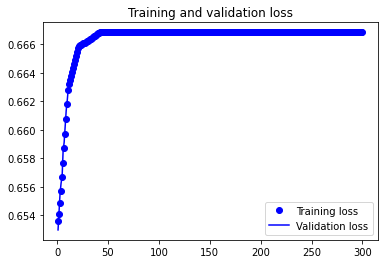

In [51]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Summary

With this reddit dataset model it is not promising chat conversion. Need a lot of improvement.